### Import Packages and Load Data (Weather + hourly load)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [17]:
df = pd.read_csv(r'/Users/jooyong/github_locals/CNS_load_forecasting/datasets/weather_load_df.csv', parse_dates=True, index_col=0)

In [18]:
df.head()

,cloud_cover,cloud_height,dew_point,evaporation,hourly_precipitation,mean_evaporation_rate,mean_potential_evaporation_rate,potential_evaporation,precipitation_type,pressure,...,wind_speed,hour,dayofweek,quarter,month,year,dayofyear,weekofyear,dayofmonth,DAYTON_MW
2004-12-31 00:00:00,1.00000,712.836487,5.282800,0.000059,0.082016,0.000016,9.387732e-07,0.000003,1.0,1021.724375,...,5.515858,0,4,4,12,2004,366,53,31,1722.0
2004-12-31 01:00:00,1.00000,1398.871460,5.731348,0.000066,0.020027,0.000018,-7.431954e-07,-0.000003,1.0,1021.066875,...,5.956858,1,4,4,12,2004,366,53,31,1596.0
2004-12-31 02:00:00,1.00000,1535.676025,5.920435,0.000061,0.018120,0.000017,-4.253816e-07,-0.000002,1.0,1020.855000,...,6.390293,2,4,4,12,2004,366,53,31,1517.0
2004-12-31 03:00:00,0.99411,1439.023438,6.182214,0.000047,0.005245,0.000013,-7.010531e-07,-0.000003,0.0,1020.400000,...,7.000507,3,4,4,12,2004,366,53,31,1486.0
2004-12-31 04:00:00,1.00000,3621.580566,6.465479,0.000035,0.063419,0.000010,-8.833595e-07,-0.000003,1.0,1020.146250,...,7.087704,4,4,4,12,2004,366,53,31,1469.0


### Data Preparation: Feature Engineering
#### - Add holidays
#### - Add lag features

In [19]:
import holidays
from datetime import datetime

df_modified = df.copy(deep=True)

df_modified['hols'] = pd.Series(df.index).apply(lambda x: holidays.CountryHoliday('US',prov='MN').get(x)).values


def non_holi(x):

  if x['hols'] == None:
    return 0

  else:
    return 1

df_modified['hols'] = df_modified.apply(non_holi, axis=1)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label = le.fit_transform(df_modified['hols'])
df_modified['hols'] = label

In [20]:
def add_legs(df):

  target_map = df['DAYTON_MW'].to_dict()

  temp_df = df.copy(deep=True)

  temp_df['lag1'] = (temp_df.index - pd.Timedelta('364 days')).map(target_map)
  temp_df['lag2'] = (temp_df.index - pd.Timedelta('728 days')).map(target_map)
  temp_df['lag3'] = (temp_df.index - pd.Timedelta('1092 days')).map(target_map)

  # temp_df['lag1'] = (temp_df.index - pd.Timedelta('24 hours')).map(target_map)
  # temp_df['lag2'] = (temp_df.index - pd.Timedelta('25 hours')).map(target_map)
  # temp_df['lag3'] = (temp_df.index - pd.Timedelta('26 hours')).map(target_map)
  # temp_df['lag4'] = (temp_df.index - pd.Timedelta('27 hours')).map(target_map)
  # temp_df['lag5'] = (temp_df.index - pd.Timedelta('28 hours')).map(target_map)
  # temp_df['lag6'] = (temp_df.index - pd.Timedelta('29 hours')).map(target_map)
  # temp_df['lag7'] = (temp_df.index - pd.Timedelta('30 hours')).map(target_map)
  # temp_df['lag8'] = (temp_df.index - pd.Timedelta('31 hours')).map(target_map)
  # temp_df['lag9'] = (temp_df.index - pd.Timedelta('32 hours')).map(target_map)
  # temp_df['lag10'] = (temp_df.index - pd.Timedelta('33 hours')).map(target_map)
  # temp_df['lag11'] = (temp_df.index - pd.Timedelta('34 hours')).map(target_map)
  # temp_df['lag12'] = (temp_df.index - pd.Timedelta('35 hours')).map(target_map)
  # temp_df['lag13'] = (temp_df.index - pd.Timedelta('36 hours')).map(target_map)
  # temp_df['lag14'] = (temp_df.index - pd.Timedelta('37 hours')).map(target_map)
  # temp_df['lag15'] = (temp_df.index - pd.Timedelta('38 hours')).map(target_map)
  # temp_df['lag16'] = (temp_df.index - pd.Timedelta('39 hours')).map(target_map)
  # temp_df['lag17'] = (temp_df.index - pd.Timedelta('40 hours')).map(target_map)
  # temp_df['lag18'] = (temp_df.index - pd.Timedelta('41 hours')).map(target_map)
  # temp_df['lag19'] = (temp_df.index - pd.Timedelta('42 hours')).map(target_map)
  # temp_df['lag20'] = (temp_df.index - pd.Timedelta('43 hours')).map(target_map)
  # temp_df['lag21'] = (temp_df.index - pd.Timedelta('44 hours')).map(target_map)
  # temp_df['lag22'] = (temp_df.index - pd.Timedelta('45 hours')).map(target_map)
  # temp_df['lag23'] = (temp_df.index - pd.Timedelta('46 hours')).map(target_map)
  # temp_df['lag24'] = (temp_df.index - pd.Timedelta('47 hours')).map(target_map)
  # temp_df['lag25'] = (temp_df.index - pd.Timedelta('48 hours')).map(target_map)
  # temp_df['lag26'] = (temp_df.index - pd.Timedelta('49 hours')).map(target_map)
  # temp_df['lag27'] = (temp_df.index - pd.Timedelta('50 hours')).map(target_map)
  # temp_df['lag28'] = (temp_df.index - pd.Timedelta('51 hours')).map(target_map)
  # temp_df['lag29'] = (temp_df.index - pd.Timedelta('52 hours')).map(target_map)
  # temp_df['lag30'] = (temp_df.index - pd.Timedelta('53 hours')).map(target_map)
  # temp_df['lag31'] = (temp_df.index - pd.Timedelta('54 hours')).map(target_map)
  # temp_df['lag32'] = (temp_df.index - pd.Timedelta('55 hours')).map(target_map)
  # temp_df['lag33'] = (temp_df.index - pd.Timedelta('56 hours')).map(target_map)
  # temp_df['lag34'] = (temp_df.index - pd.Timedelta('57 hours')).map(target_map)
  # temp_df['lag35'] = (temp_df.index - pd.Timedelta('58 hours')).map(target_map)
  # temp_df['lag36'] = (temp_df.index - pd.Timedelta('59 hours')).map(target_map)

  return temp_df

df_modified = add_legs(df_modified)


### Train the Model (lightgbm)

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
def evaluate(y, pred):
    
    rmse = np.sqrt(mean_squared_error(y, pred))

    return rmse

In [23]:
X_train = df_modified[df_modified['year']<2018].drop('DAYTON_MW', axis=1)
y_train = df_modified[df_modified['year']<2018]['DAYTON_MW']

X_test = df_modified[df_modified['year']==2018].drop('DAYTON_MW', axis=1)
y_test = df_modified[df_modified['year']==2018]['DAYTON_MW']

In [24]:
lr = lgb.LGBMRegressor()

lr.fit(X=X_train, y=y_train)

pred = lr.predict(X_test)

rmse = evaluate(y_test, pred)


### Visualize the result

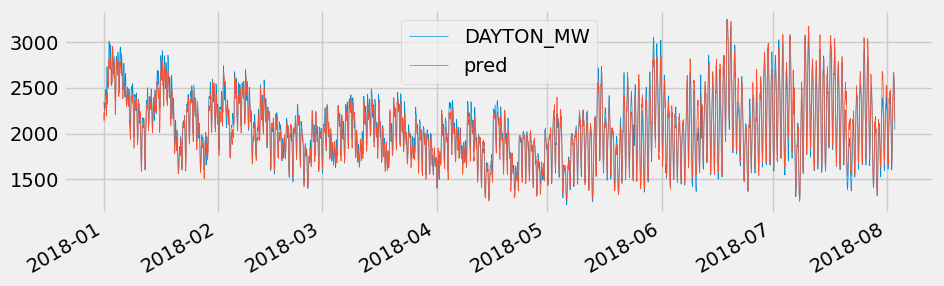

In [31]:
y_test = pd.DataFrame(y_test)
y_test['pred'] = pred


plt.figure(figsize=(10, 3))
y_test['DAYTON_MW'].plot(lw=0.5)
y_test['pred'].plot(lw=0.5)
plt.legend()

In [32]:
rmse

94.98371672599934